# Logistic Regression from Scratch

Representing a single neuron from scratch using numpy

In [280]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

### Loading the dataset and preprocessing

In [281]:
def load_dataset(path):
    '''
    Function to load the dataset
    '''
    
    f = h5py.File(path, 'r')
    x_key = list(f.keys())[1]
    y_key = list(f.keys())[2]
    
    X_data = f[x_key]
    y_data = f[y_key]
    
    return (X_data, y_data)

In [282]:
X_train, y_train = load_dataset('Dataset\\train_catvnoncat.h5')
X_test, y_test = load_dataset('Dataset\\test_catvnoncat.h5')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(209, 64, 64, 3)
(209,)
(50, 64, 64, 3)
(50,)


0


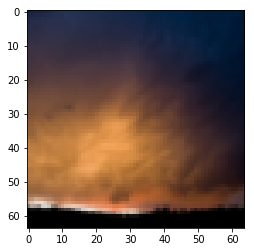

In [285]:
plt.imshow(X_train[0])
print(y_train[0])

1


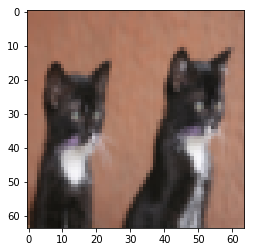

In [286]:
plt.imshow(X_test[0])
print(y_test[0])

In [287]:
# Flatten the input image to the shape (number_of_features, number_of_examples)

X_train = np.reshape(X_train, (X_train.shape[0], -1)).T
X_test = np.reshape(X_test, (X_test.shape[0], -1)).T

print(X_train.shape)
print(X_test.shape)

(12288, 209)
(12288, 50)


In [288]:
# Reshape y from (num_of_examples, ) to (1, num_of_examples)

y_train = np.reshape(y_train, (1, -1))
y_test = np.reshape(y_test, (1, -1))

print(y_train.shape)
print(y_test.shape)

(1, 209)
(1, 50)


In [289]:
# Normalizing the pixel intensities

X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

print(X_train.max())
print(X_test.max())

1.0
1.0


### Helper Functions

In [291]:
def sigmoid(z):
    '''
    Takes z as input and returns the sigmoid of z
    '''
    return 1 / (1 + np.exp(-z))

In [292]:
def initialize_parameters(dim):
    '''
    Initialize the weights vector of shape(dim, 1) and bias as a scalar
    '''
    
    W = np.zeros((dim, 1)) # initialize weights as a column vector
    b = 0.
    
    return W,b

In [293]:
def single_iteration_of_gradient_descent(X, y, W=None, b=None):
    '''
    Performs Forward Propagation and Back Propagation of entire training set
    Input: X (n_features,n_examples), y (1,n_examples)
    Output: a dictionary grad with dW (1, n_features), db (scalar) and the cost J (scalar)
    '''
    
    # What is the number of input features nx, number of training examples m?
    nx, m = X.shape[0], X.shape[1]
    
    # Initialize weights and bias
    if W.all() == None and b == None:
        '''
        Dummy code - This if condition won't run
        '''
        W, b = inititalize_parameters(nx)
    
    # Assert shapes
    assert(W.shape[0] == X.shape[0])
    assert(y.shape == (1, m))
    
    # Compute Z=(W.T . X) + b <W: (nx, 1), X: (nx,m), b: scalar>
    Z = np.dot(W.T, X) + b 
    
    # Compute activation function, yhat = A = sigmoid(z) <Z: (1,m), A: (1,m)>
    A = sigmoid(Z)
    assert(A.shape == (1, m))
    
    # Compute cost function, J = (-1/m)SUMMATION(y log(yhat) + (1-y) log(1-yhat)) <y: (1,m), A:(1,m), J: scalar>
    J = (-1 / m) * np.sum((y * np.log(A)) + ((1-y) * np.log(1-A)))
    
    # Compute derivative of J wrt z, dZ = A - y <A: (1,m), y: (1,m), dZ:(1,m)>
    dZ = A - y
    
    # Compute derivative of J wrt W, dW = X . dz.T <X: (nx,m), dZ:(1,m), dW:(nx,1)>
    dW = (1 / m) * np.dot(X, dZ.T)
    
    # Compute derivative of J wrt b, db = (1/m) SUMMATION(dz) <dZ: (1,m), db: scalar>
    db = (1 / m) * np.sum(dZ)
    
    # Store the gradients in a dictionary grad
    grad = {
        'dW' : dW,
        'db' : db
    }
    
    # Return the cost function and parms
    return grad, J

In [294]:
def train(X, y, num_epochs, learning_rate, verbose):
    '''
    Run training for given number of epochs and update the weights and bias as per the learning rate
    Input: X_train, y_train, number of epochs, learning rate or alpha, verbose=(True|False)
    Output: A dictionary params representing the updated weights and bias and list of losses/costs for each epoch
    '''
    
    W, b = initialize_parameters(X.shape[0])
    cost = []        

    for i in range(1, num_epochs+1):
        
        grad, J = single_iteration_of_gradient_descent(X, y, W, b)
            
        W = W - (learning_rate * grad['dW'])
        b = b - (learning_rate * grad['db'])
        
        cost.append(J)
        
        if verbose:
            if i == 1 or i % 50 == 0:
                print("Epoch: {}, Loss: {}".format(i, J))
    
    params = {
        'W' : W,
        'b' : b
    }
    
    return params, cost

In [295]:
def predict(X, W, b, threshold):
    '''
    Predict the class given the input data in the shape (num_features, num_examples)
    Output: A numpy array of shape (1, num_examples) containing the predictions
    '''
    
    assert(W.shape[0] == X.shape[0])
    m = X.shape[1]
    
    # Compute Z = (W.t . X) + b
    Z = np.dot(W.T, X) + b
    
    # Compute A = sigmoid(Z)
    A = sigmoid(Z)
    
    # Compute yhat = {float(0) if A < threshold | float(1) if A >= threshold} 
    # using elegent lamda function and list comprehension
    yhat = [(lambda pred: 0. if activation < threshold else 1.)(activation) for activation in A[0]]
    
    # Convert yhat to np.array and reshape it to match y
    yhat = np.array(yhat).reshape(1,-1)
    
    return yhat
            

### Merge all the helper functions into a regressor model

In [297]:
def regressor(X_train, y_train, X_test, y_test, num_epochs=1000, learning_rate=0.01, verbose=True, threshold=0.5):
    '''
    Main Function that calls the helper functions, calculates training and test accuracy
    Output: A dictionary representing the regressor model
    '''
    
    # Run training on training set
    params, cost = train(X_train, y_train, num_epochs, learning_rate, verbose)
    
    # Isolate the weights and bias
    W = params['W']
    b = params['b']
    
    # Run predictions on train and test set
    yhat_train = predict(X_train, W, b, threshold)
    yhat_test = predict(X_test, W, b, threshold)
    
    # Compute train and test accuracy
    train_acc = 100 - np.mean(np.abs(yhat_train - y_train)) * 100
    test_acc = 100 - np.mean(np.abs(yhat_test - y_test)) * 100
    print("Train accuracy: {}".format(train_acc))
    print("Test accuracy: {}".format(test_acc))
    
    # Store the model in a dictionary and return the dictionary
    model = {
        'costs' : cost,
        'W' : W,
        'b' : b,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'epochs': num_epochs,
        'learning_rate': learning_rate
    }
          
    return model
    

In [298]:
# Run training

model = regressor(X_train, y_train, X_test, y_test, num_epochs=1000, learning_rate=0.005, verbose=True, threshold=0.5)

Epoch: 1, Loss: 0.6931471805599453
Epoch: 50, Loss: 0.7567072652986896
Epoch: 100, Loss: 0.6448978829531701
Epoch: 150, Loss: 0.5570678386755334
Epoch: 200, Loss: 0.4848936141484849
Epoch: 250, Loss: 0.42499700069954943
Epoch: 300, Loss: 0.37776149521638064
Epoch: 350, Loss: 0.34883546490049683
Epoch: 400, Loss: 0.3317754055523586
Epoch: 450, Loss: 0.31694809716059336
Epoch: 500, Loss: 0.3035286720260553
Epoch: 550, Loss: 0.2913006713137132
Epoch: 600, Loss: 0.28009427757967503
Epoch: 650, Loss: 0.2697730995328459
Epoch: 700, Loss: 0.2602258475628189
Epoch: 750, Loss: 0.25136051682504507
Epoch: 800, Loss: 0.24310018399838854
Epoch: 850, Loss: 0.23537989675548907
Epoch: 900, Loss: 0.22814432769465368
Epoch: 950, Loss: 0.2213459761826659
Epoch: 1000, Loss: 0.21494377069682485
Train accuracy: 96.65071770334929
Test accuracy: 72.0


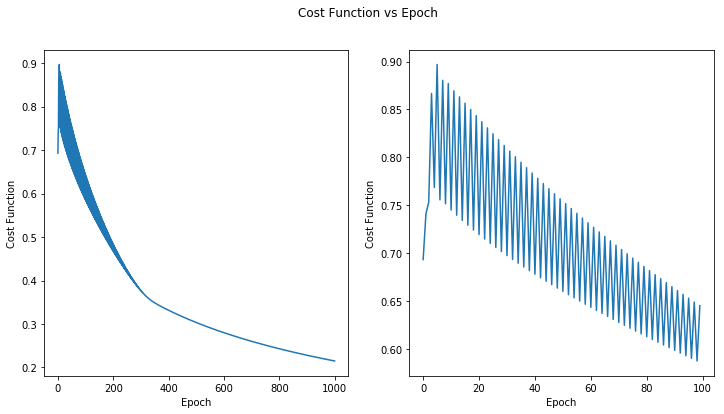

In [299]:
# Plotting the cost function

costs = model['costs']

fig = plt.figure(figsize=(12,6))
axes = fig.subplots(nrows=1, ncols=2)

axes[0].plot(costs)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Cost Function")

axes[1].plot(costs[:100])
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Cost Function")

fig.suptitle("Cost Function vs Epoch")

plt.show()